In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt

## Load Configs and Define Circuit

define FPGA config; this has timing information for the scheduler. For now it is fine to use the following hardcoded config

In [2]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 
                            'alu_instr_clks': 5, 
                            'jump_cond_clks': 5, 
                            'jump_fproc_clks': 5, 
                            'pulse_regwrite_clks': 3})

load channel configs (firmware channel mapping + configuration, see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details), and QChip object, which contains calibrated gates + readout.


In [3]:
channel_configs = load_channel_configs('channel_config.json')
qchip = qc.QChip('qubitcfg.json')

As an alternative to the above, if you're using the chipcalibration repository, you can load all three configs like this:

In [4]:
import chipcalibration.config as cfg
chipname = 'X4Y2' #this is a folder in the 'qchip' submodule of chipcalibration, containing the name of your chip
fpga_config, qchip, channel_config = cfg.load_configs(chipname)

Define the quantum circuit, as before. Due to register size limitations, the max supported ACQ trigger delay relative to circuit start is 131 microseconds. However, shots are taken one at a time (not in batches of 1000, as with the integrated IQ shots), so readback/trigger time alone should be sufficient for qubit to decay.

In [5]:
circuit = [
    #max out delay time
    {'name': 'delay', 't': 131.0715e-6},  
    
    #This time, use calibrated gates for measurement. Boost the amplitude to make the readout pulse easy to see.
    {'name': 'read', 'qubit': 'Q1', 'modi':{(0, 'amp'): 0.2}}
]

## Compile and Assemble

Compile the program. The output of the compile stage is a distributed processor assembly program, which consists of initialization/termination statements, as well as a list of scheduled pulses for each core. Notice that the calibrated X90 gates resolve to the same pulse as the manually specified pi/2 pulses. This time, our program uses two cores, one scoped to `('Q1.qdrv', 'Q1.rdrv', 'Q1.rdlo')`, and another to `('Q2.qdrv', 'Q2.rdrv', 'Q2.rdlo')`.

In [6]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
compiled_prog.program

{('Q1.qdrv', 'Q1.rdrv', 'Q1.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 6558671869.775688,
   'phase': 0.0,
   'amp': 0.2,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 65541,
   'dest': 'Q1.rdrv'},
  {'op': 'pulse',
   'freq': 6558671869.775688,
   'phase': 0,
   'amp': 1.0,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 65841,
   'dest': 'Q1.rdlo'},
  {'op': 'done_stb'}]}

Run the assembler to convert the above program into machine code that we can load onto the FPGA:

In [7]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

## Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client:

In [11]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247', port=9095)

Submit the circuit to the server, and collect 400 shots. `trig_delay` is the start time of the trace acquisition relative to circuit start. Expect this to be MUCH slower than collecting the equivalent number of shots of integrated IQ data. You can also specify which channel(s) (up to 2) to use, a decimation factor, and the number of samples to acquire with each trace (see docs for details).

In [4]:
acq_data = runner.load_and_run_acq(raw_asm, n_total_shots=400, trig_delay=131.0715e-6)

Object `runner.load_and_run_acq` not found.


In [97]:
0.5e-9*262140

0.00013107

`acq_data['0']` contains (non-downconverted) ADC traces from the readout channel. The array has shape `(n_total_shots, nsamples)`

In [51]:
acq_data.keys()

dict_keys(['0'])

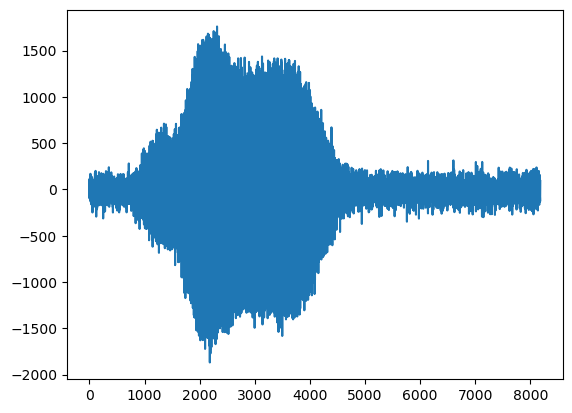

In [52]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #no prog delay, no acq delay

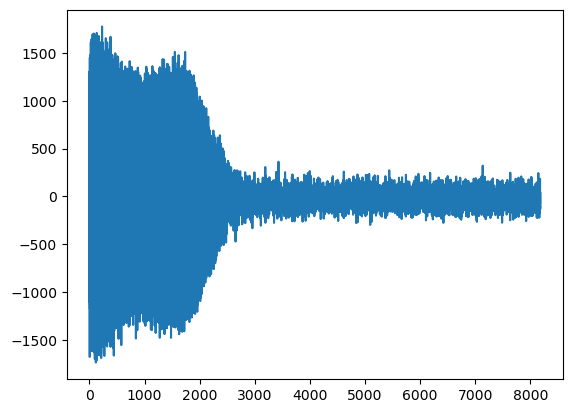

In [54]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #no prog delay, 2000 sample acq delay

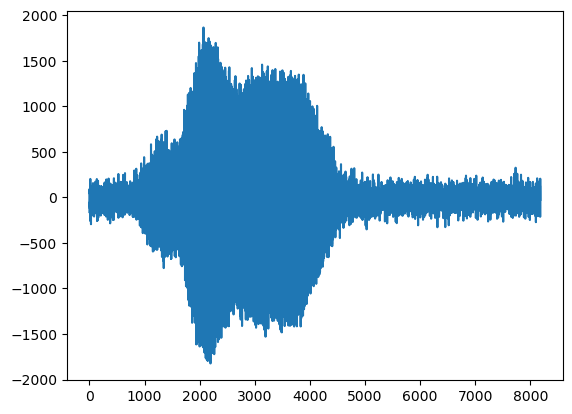

In [60]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #2000*2.e-9 prog delay, 2000 sample acq delay

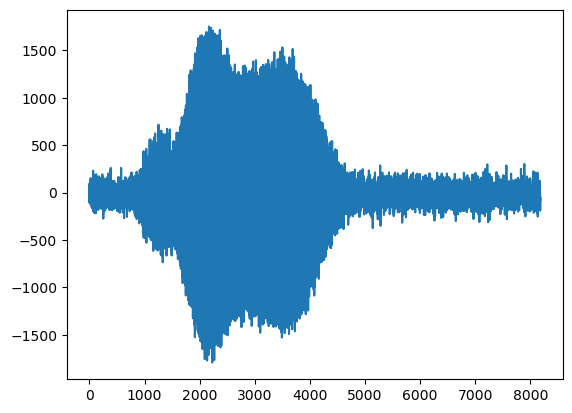

In [69]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #20000*2.e-9 prog delay, 20000 sample acq delay

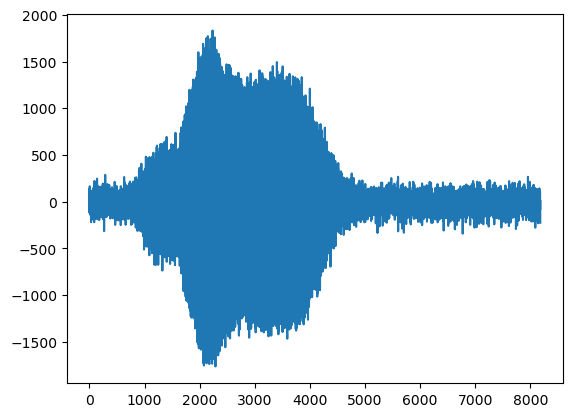

In [86]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #100000*2.e-9 prog delay, 100000 sample acq delay

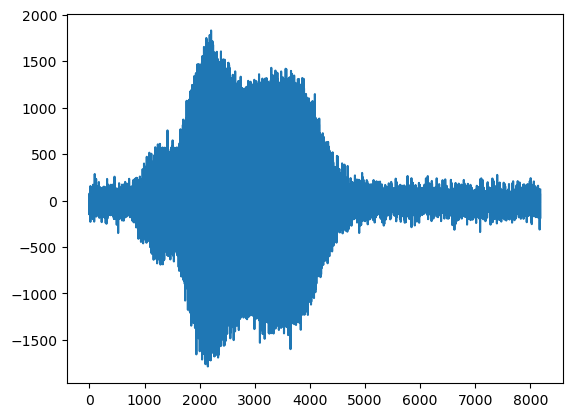

In [92]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #262143*2.e-9 prog delay, 262143 sample acq delay

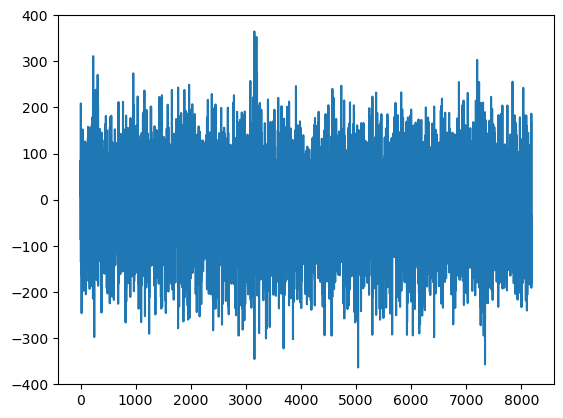

In [94]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) #262143*2.e-9 prog delay, 262145 sample acq delay

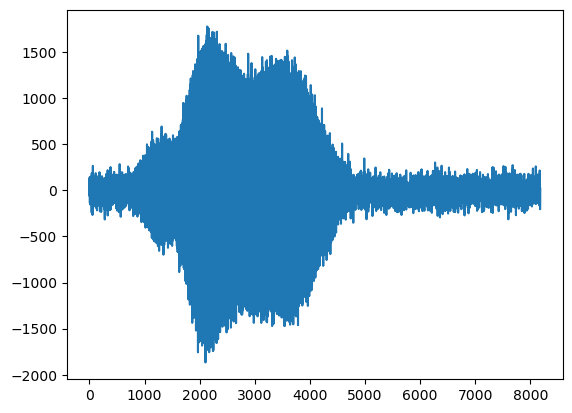

In [13]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) 

In [2]:
plt.plot(np.average(acq_data['0'], axis=0)[10:]) 

NameError: name 'plt' is not defined

In [1]:
0.5e-9*262143

0.0001310715